<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Data-Set-and-Programming-Problem-Overview" data-toc-modified-id="Data-Set-and-Programming-Problem-Overview-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Set and Programming Problem Overview</a></span></li></ul></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ridge Regression</a></span></li></ul></div>

# Homework 2: Lasso Regression

## Introduction

In this homework you will investigate regression with $l_1$ regularization, both implementation techniques and theoretical properties. On the methods side, you’ll work on coordinate descent (the “shooting algorithm”), homotopy methods, and \[optionally\] projected SGD. On the theory side you’ll derive the largest $l_1$ regularization parameter you’ll ever need to try, and optionally you’ll derive the explicit solution to the coordinate minimizers used in coordinate descent, you’ll investigate what happens with ridge and lasso regression when you have two copies of the same feature, and you’ll work out the details of the classic picture that “explains” why $l_1$ regularization leads to sparsity.

### Data Set and Programming Problem Overview

- For the experiments, we are generating some artifical data using code in the file setup_problem.py
- We are considering the regression setting with the 1-dimensional input space $R$. 
- An image of the training data, along with the target function (i.e. the Bayes prediction function for the square loss function) is shown in Figure 1 below.

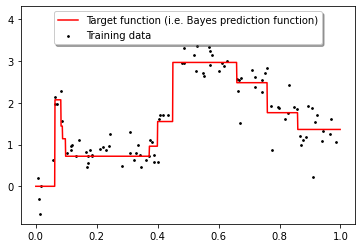

In [1]:
from setup_problem import *
%run setup_problem.py

- The target function is a highly nonlinear function of the input. 
- To handle this sort of problem with linear hypothesis spaces, we will need to create a set of features that perform nonlinear transforms of the input.
- A detailed description of the technique we will use can be found in the Jupyter notebook basis-fns.ipynb.

- In this assignment, we are providing you with a function that takes care of the featurization. This is the “featurize” function, returned by the generate_problem function in setup_problem.py.
- The generate_problem function also gives the true target function, which has been constructed to be a sparse linear combination of our features.
- The coefficients of this linear combination are also provided by generate_problem, so you can compare the coefficients of the linear functions you find to the target function coefficients.
- The generate_problem function also gives you the train and validation sets that you should use.

## Ridge Regression

The ridge regression objective function: $$ J(w, \lambda) = \frac{1}{n} \sum_{i=1}^n(w^Tx_i - y_i)^2 + \lambda\|w\|^2   $$

1. Run ridge regression on the provided training dataset. Choose the $\lambda$ that minimizes the empirical risk (i.e. the average square loss) on the validation set. Include a table of the parameter values you tried and the validation performance for each. Also include a plot of the results.

In [2]:
x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize = load_problem('lasso_data.pickle')

In [3]:
x_train

array([0.66656527, 0.21099131, 0.98576502, 0.83007921, 0.4173425 ,
       0.79914531, 0.75793622, 0.57063288, 0.57901931, 0.11847408,
       0.7728778 , 0.01846007, 0.48549037, 0.90532834, 0.34524665,
       0.52598929, 0.87812873, 0.71102939, 0.91785725, 0.81949944,
       0.52841268, 0.18444641, 0.66066791, 0.34151433, 0.17131441,
       0.0145817 , 0.67005126, 0.56746115, 0.30953677, 0.92460315,
       0.22157251, 0.18305074, 0.7936761 , 0.7412013 , 0.96562532,
       0.86924979, 0.47947701, 0.05568619, 0.01052375, 0.06852684,
       0.61011903, 0.43422072, 0.67360635, 0.66433739, 0.85583472,
       0.23127884, 0.16737973, 0.3100852 , 0.71910866, 0.84699593,
       0.00771939, 0.74271395, 0.75167063, 0.94228665, 0.61627136,
       0.86785038, 0.96914286, 0.32087559, 0.10226573, 0.11437291,
       0.48689924, 0.88819266, 0.36110722, 0.549953  , 0.24197779,
       0.13234472, 0.89236379, 0.57310452, 0.14130257, 0.1643654 ,
       0.40078095, 0.08202477, 0.90844137, 0.33647625, 0.17849

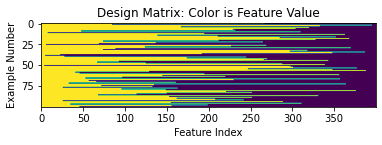

In [4]:
# Generate features
X_train = featurize(x_train)
X_test = featurize(x_test)

#Visualize training data
fig, ax = plt.subplots()
ax.imshow(X_train)
ax.set_title("Design Matrix: Color is Feature Value")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
plt.show(block=False)

In [5]:
from ridge_regression import *

# Compare our RidgeRegression to sklearn's.
compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1)

Hoping this is very close to 0:6.203144003584323e-11


In [6]:
# Do hyperparameter tuning with our ridge regression
grid, results = do_grid_search_ridge(X_train, y_train, X_test, y_test)
print(results)
min_idx = results['mean_test_score'].idxmin()
print('The regression parameter that minimizes test loss was {:.2e}.'.format(results['param_l2reg'][min_idx]))

    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422
The regression parameter that minimizes test loss was 1.00e-02.


Text(0, 0.5, 'Mean Squared Error')

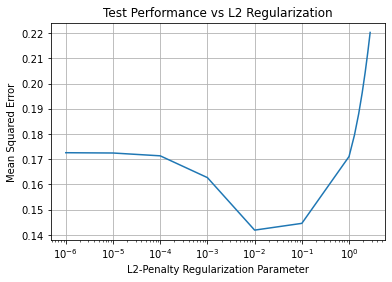

In [7]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
#ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.grid()
ax.set_title("Test Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")

In [8]:
#Choice of prediction function:
ridge_regression_estimator_chosen = RidgeRegression(l2reg=0.01)
pred_fn = ridge_regression_estimator_chosen.fit(X_train, y_train)
our_coefs = ridge_regression_estimator_chosen.w_

2. Now we want to visualize the prediction functions. On the same axes, plot the following: the training data, the target function, an unregularized least squares fit (still using the featurized data), and the prediction function chosen in the previous problem. Next, along the lines of the bar charts produced by the code in compare_parameter_vectors, visualize the coefficients for each of the prediction functions plotted, including the target function. Describe the patterns, including the scale of the coefficients, as well as which coefficients have the most weight.

In [9]:
# Let's plot prediction functions and compare coefficients for several fits
# and the target function.
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

l2regs = [0, grid.best_params_['l2reg'], 1]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X) })

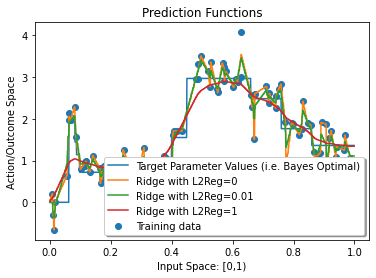

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('Input Space: [0,1)')
ax.set_ylabel('Action/Outcome Space')
ax.set_title("Prediction Functions")
plt.scatter(x_train, y_train, label='Training data')
for i in range(len(pred_fns)):
    ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
legend = ax.legend(loc='best', shadow=True)

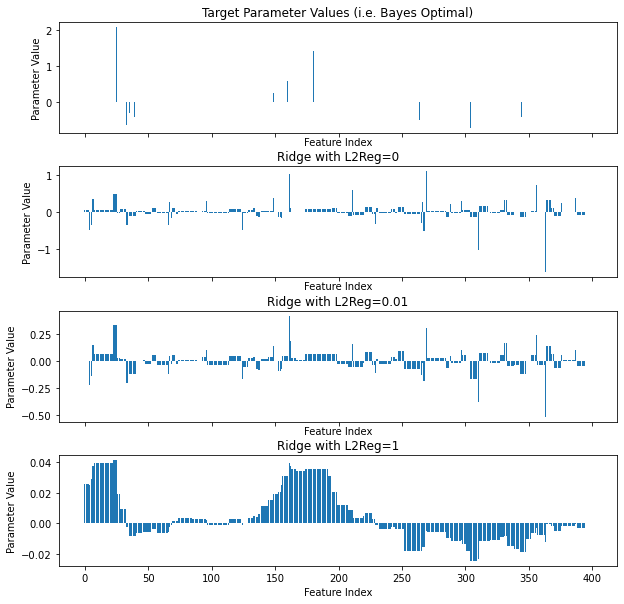

In [11]:
fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize=(10,10))
num_ftrs = len(pred_fns[0]["coefs"])
for i in range(len(pred_fns)):
    title = pred_fns[i]["name"]
    coef_vals = pred_fns[i]["coefs"]
    axs[i].bar(range(num_ftrs), coef_vals)
    axs[i].set_xlabel('Feature Index')
    axs[i].set_ylabel('Parameter Value')
    axs[i].set_title(title)

fig.subplots_adjust(hspace=0.3)

The scale of the parameter value decreases with increased $\lambda$ (as expected! The regulation parameter forces the weights to take smaller values.) Features with the most weight are distributed around the indexes of features present in the Bayes Optimal prediction function, and share the same +/- sign.

3. For the chosen λ, examine the model coefficients. For ridge regression, we don’t expect any parameters to be exactly 0. However, let’s investigate whether we can predict the sparsity pattern of the true parameters (i.e. which parameters are 0 and which are nonzero) by thresholding the parameter estimates we get from ridge regression. We’ll predict that $w_i = 0$ if $|\hat{w}_i| < \epsilon$ and $w_i \neq 0$ otherwise. Give the confusion matrix for $\epsilon = 10^{−6}, 10^{−3}, 10^{−1}$, and any other thresholds you would like to try.

In [12]:
ridge_regression_estimator_chosen = RidgeRegression(l2reg=0.01)
pred_fn = ridge_regression_estimator_chosen.fit(X_train, y_train)
regr_coefs = ridge_regression_estimator_chosen.w_

In [13]:
from sklearn.metrics import confusion_matrix
for epsilon in [1e-6, 1e-3, 1e-1]:
    a = np.zeros(regr_coefs.size)
    b = np.zeros(regr_coefs.size)
    for i in range(len(regr_coefs)):
        if np.abs(regr_coefs[i]) < epsilon:
            a[i] = 0
        else:
            a[i] = 1
    for j in range(len(coefs_true)):
        if coefs_true[j] != 0:
            b[j] = 1
    tn, fp, fn, tp = confusion_matrix(a, b).ravel()
    print(tn, fp, fn, tp)

5 0 385 10
8 0 382 10
349 3 41 7
